# Import Libraries

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.manifold import TSNE

from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans



# Load the dataset

The dataset was collected from Kaggle and consists of credit card transactions, each described by 30 features, including time, amount, and 28 anonymized variables resulting from a PCA transformation. The objective is to detect fraudulent transactions, which are highly imbalanced in the dataset, with fraudulent cases being only 0.17% of the total. This necessitates robust analysis and modeling to accurately identify fraud while minimizing false positives.

The main purpose of the provided code is to explore and evaluate different clustering methods—DBSCAN and hierarchical clustering—on the credit card transaction data, particularly to detect potential fraudulent transactions. By applying dimensionality reduction with PCA, the code visualizes the clusters formed by each method and calculates silhouette scores to assess the quality and meaningfulness of these clusters in identifying patterns or anomalies that could indicate fraud.

In [4]:

file_path = 'creditcard.csv'  # Make sure this path points to your dataset file
data = pd.read_csv(file_path)

# Data Descripition and Information

In [4]:
# Display the first few rows of the dataset
print(data.head())

# Get basic information about the dataset
print(data.info())

# Get summary statistics of the dataset
print(data.describe())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

We can see that our data have alreayd been normalized and reduced by using a PCA method

# Data Visualization

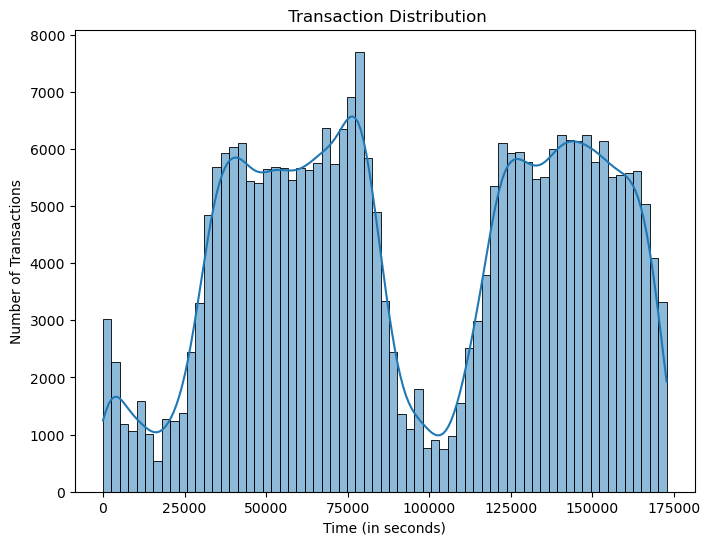

In [5]:

plt.figure(figsize=(8, 6))
sns.histplot(data['Time'], kde=True)
plt.title(' Transaction Distribution')
plt.ylabel('Number of Transactions')
plt.xlabel('Time (in seconds)')
plt.show()


The distribution of transaction times appears to have two distinct peaks, indicating that transactions tend to cluster around two specific time periods. This could correspond to different times of day, such as business hours and evening hours, where credit card usage is more frequent.

In addition, the number of transactions varies significantly over time, with some intervals seeing much higher transaction volumes than others. The peaks might represent times when people are more likely to make purchases, such as during midday or late evening.

Understanding the distribution of transaction times can be important for identifying patterns of normal versus fraudulent activity. For instance, if fraudulent transactions tend to occur at times when overall transaction volume is low, this could be a useful insight for fraud detection models.

# Data Exploration

In [6]:
# Check for missing values
missing_values = data.isnull().sum()
print("Missing values in each column:\n", missing_values)


Missing values in each column:
 Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


In [7]:

# Separate the data into fraudulent and non-fraudulent transactions
fraud = data[data['Class'] == 1]
non_fraud = data[data['Class'] == 0]


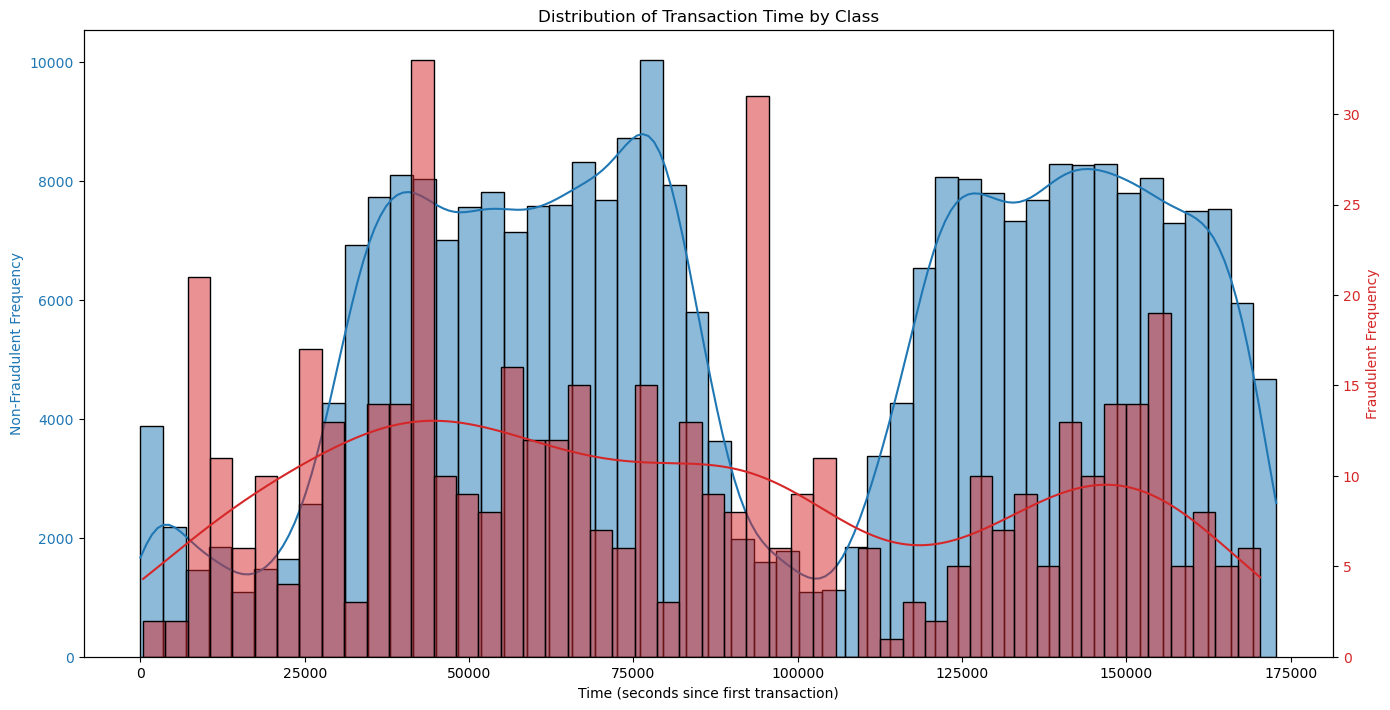

In [8]:
fig, ax1 = plt.subplots(figsize=(14, 7))

color = 'tab:blue'
ax1.set_xlabel('Time (seconds since first transaction)')
ax1.set_ylabel('Non-Fraudulent Frequency', color=color)
sns.histplot(non_fraud['Time'], bins=50, color=color, kde=True, ax=ax1, label='Non-Fraudulent')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Fraudulent Frequency', color=color)  # we already handled the x-label with ax1
sns.histplot(fraud['Time'], bins=50, color=color, kde=True, ax=ax2, label='Fraudulent')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Distribution of Transaction Time by Class')
plt.show()


### Density Plot

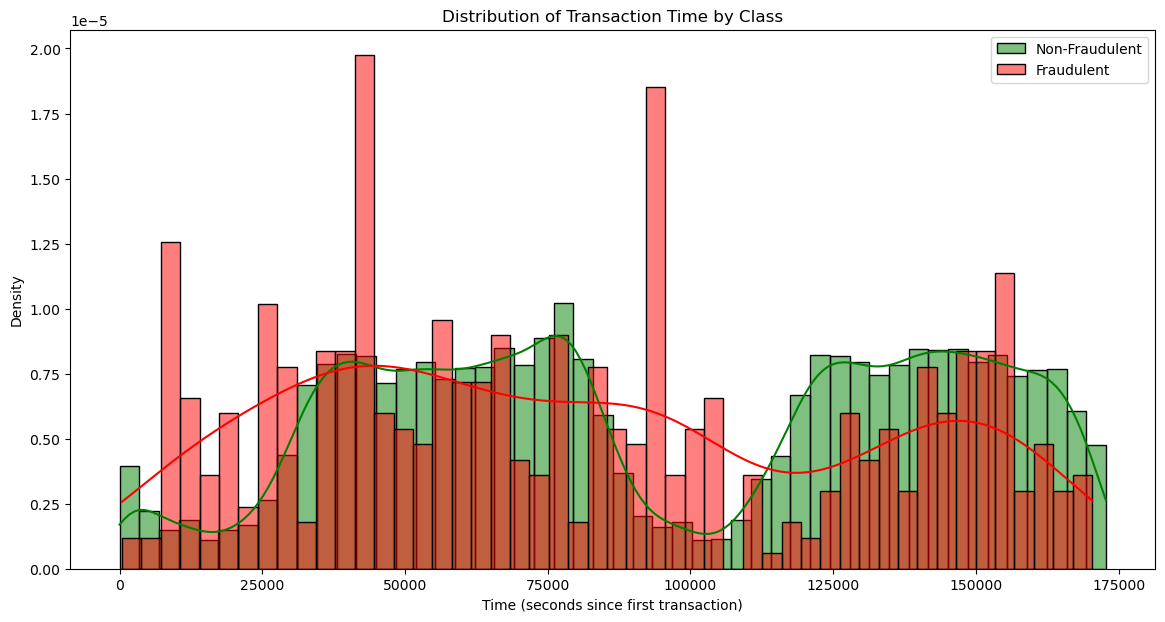

In [9]:
plt.figure(figsize=(14, 7))

sns.histplot(non_fraud['Time'], bins=50, color='green', kde=True, label='Non-Fraudulent', stat='density')
sns.histplot(fraud['Time'], bins=50, color='red', kde=True, label='Fraudulent', stat='density')

plt.title('Distribution of Transaction Time by Class')
plt.xlabel('Time (seconds since first transaction)')
plt.ylabel('Density')
plt.legend()
plt.show()


This density plot shows the distribution of transaction times for both fraudulent (red) and non-fraudulent (blue) transactions.

The fraudulent transactions are more concentrated at specific times, with notable spikes around 25,000, 75,000, and 150,000 seconds. These peaks suggest that fraud might be more likely during certain periods, possibly reflecting behavioral patterns of fraudulent activity. The non-fraudulent transactions, which are more evenly distributed over time but also show some concentration at similar time intervals, though generally more spread out.

### Let's take a look at the Fraudulent transactions

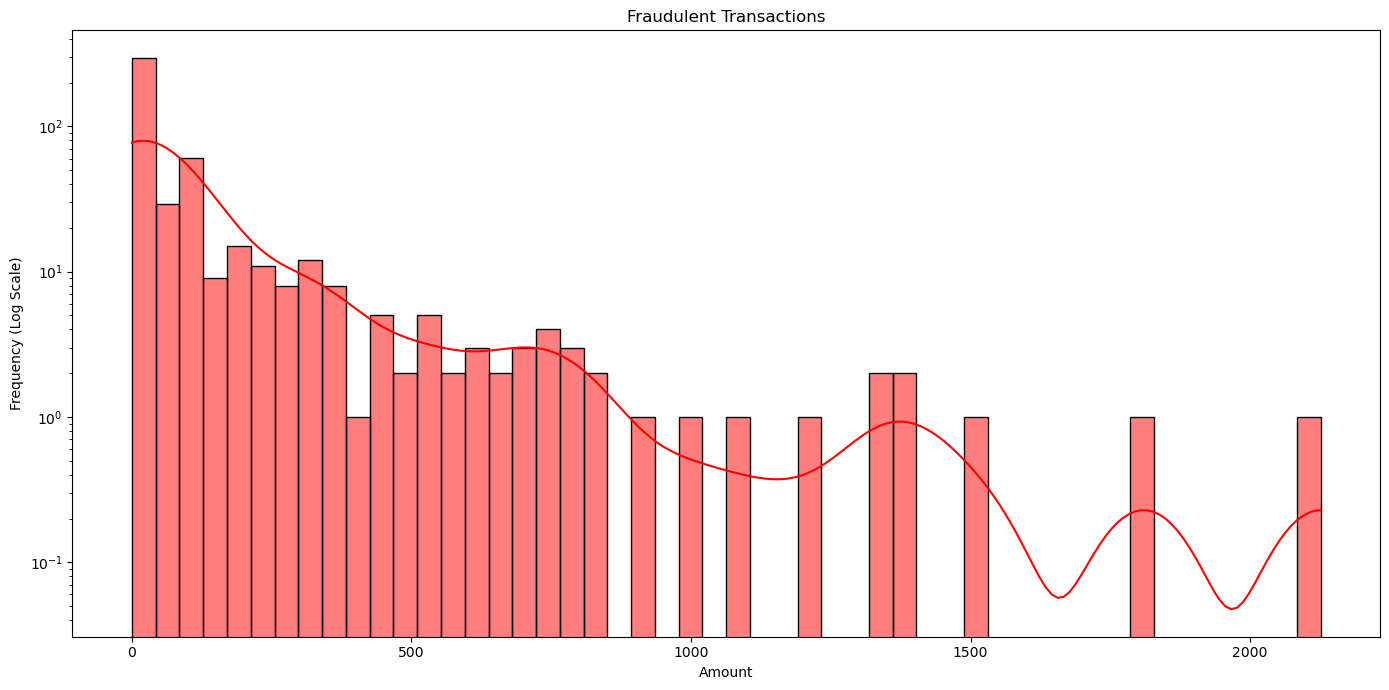

In [28]:

# Fraudulent Transactions

plt.figure(figsize=(14, 7))
sns.histplot(fraud['Amount'], bins=50, kde=True, color='red', log_scale=(False, True))
plt.title('Fraudulent Transactions')
plt.xlabel('Amount')
plt.ylabel('Frequency (Log Scale)')

plt.tight_layout()
plt.show()


Fraudulent transactions mostly occur at lower amounts.

## Correlation Matrix

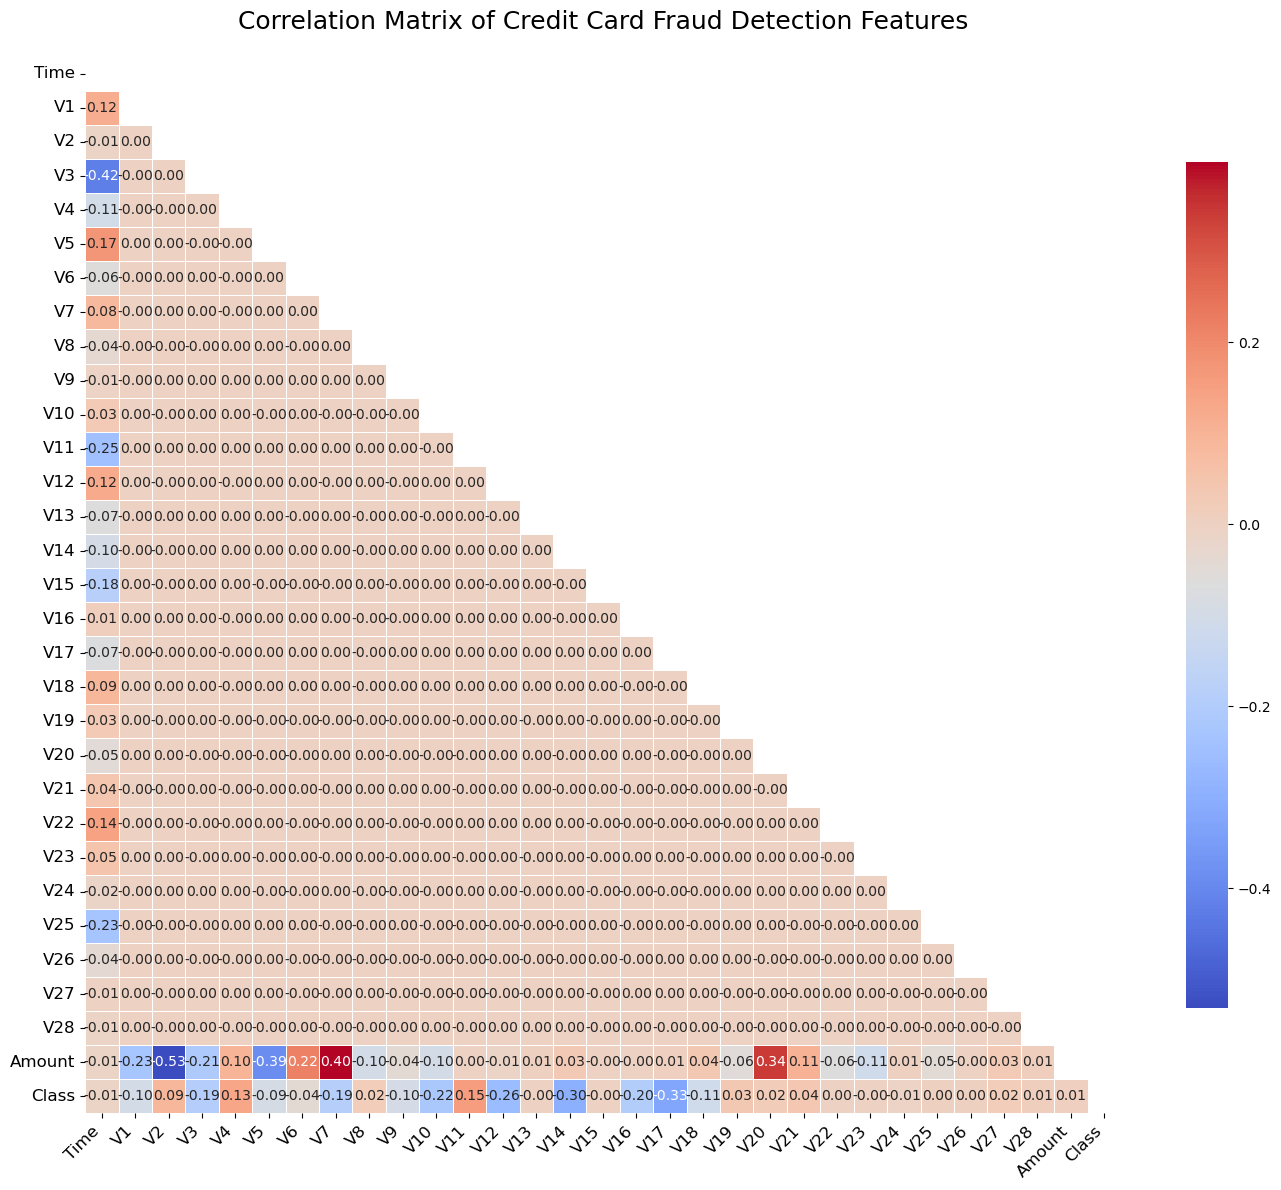

In [5]:
correlation_matrix = data.corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(14, 12))

# Customize the heatmap with more distinct colors and formatting
sns.heatmap(correlation_matrix, mask=mask, cmap='coolwarm', annot=True, fmt=".2f",
            annot_kws={"size": 10}, cbar_kws={"shrink": .8}, linewidths=0.5, linecolor='white')

# Rotate the x labels to make them easier to read
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Improve the title and layout
plt.title('Correlation Matrix of Credit Card Fraud Detection Features', fontsize=18, pad=20)
plt.tight_layout()

# Show the plot
plt.show()

The majority of features (V1 to V28) are uncorrelated due to the PCA transformation, which is designed to reduce dimensionality while capturing the most variance in the data.
The modeling implications due to the low correlation between individual features and the Class variable suggests that detecting fraud in this dataset will likely require the use of sophisticated models that can capture non-linear relationships and interactions between features. In addtion, features like V11, V4, and V17 may be particularly important for the model due to their relatively higher correlation with the target variable.

## Outlier Detection

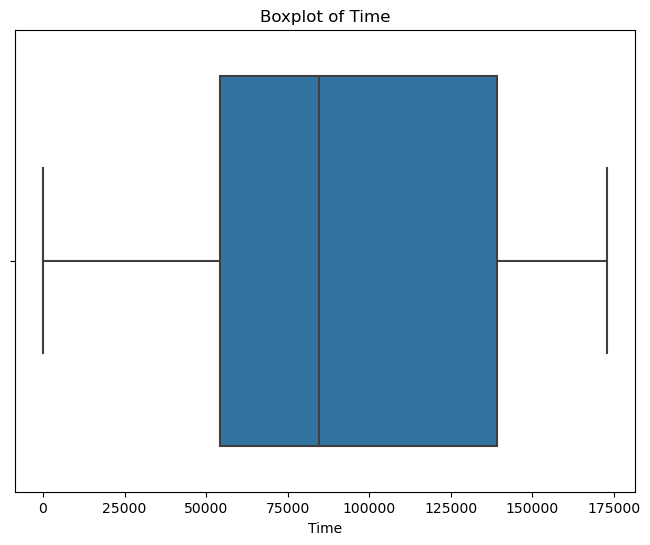

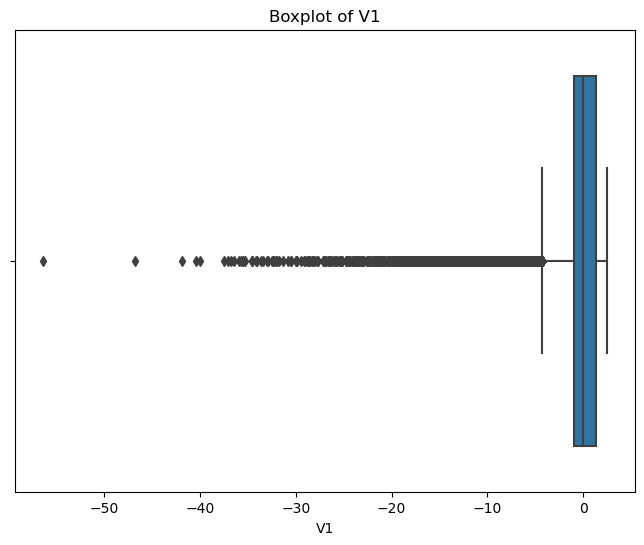

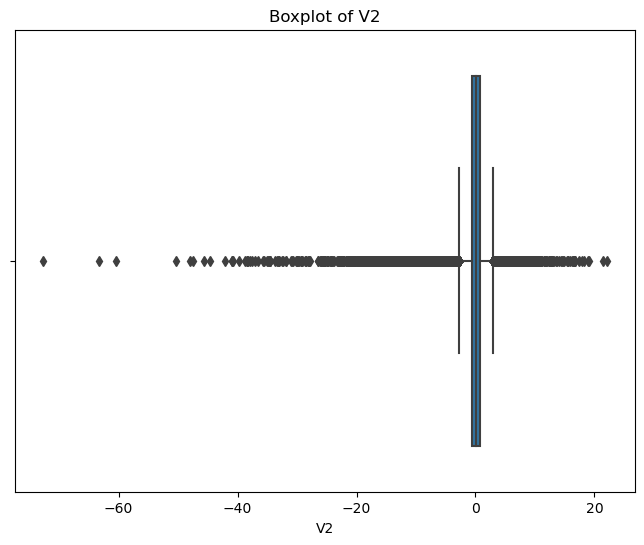

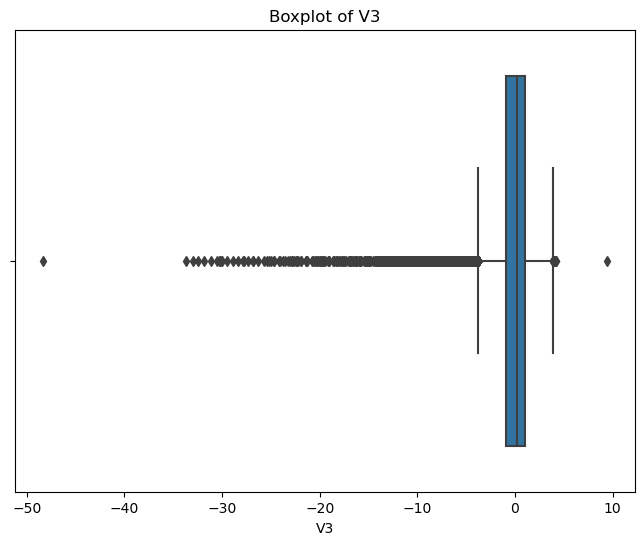

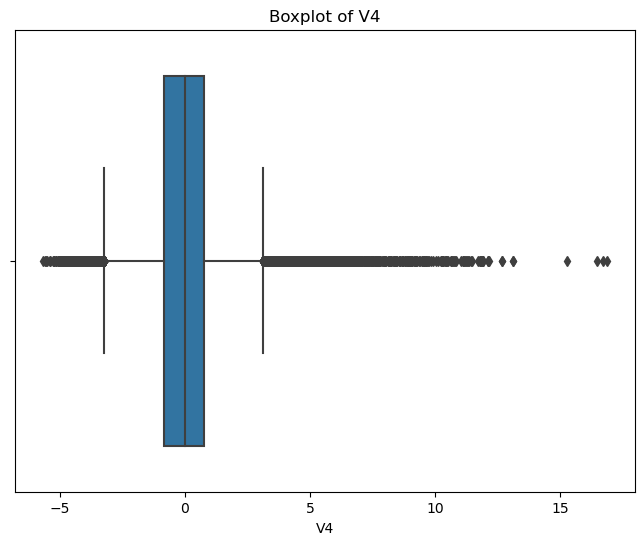

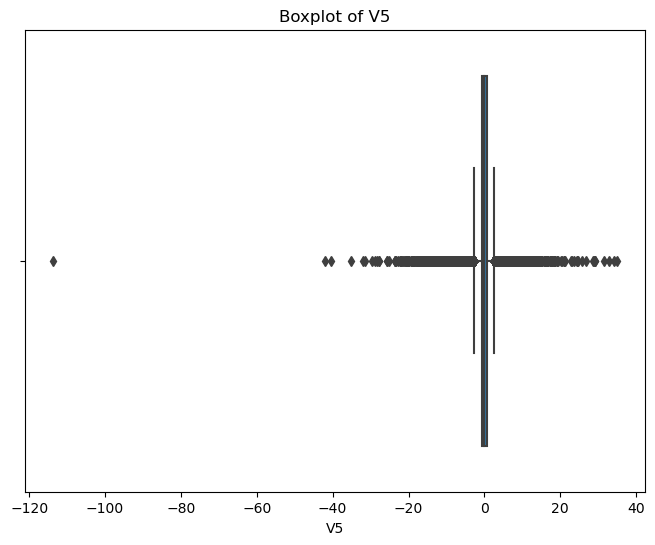

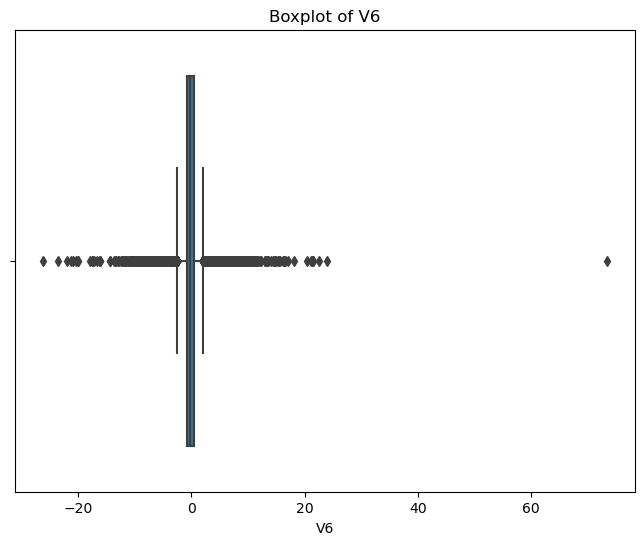

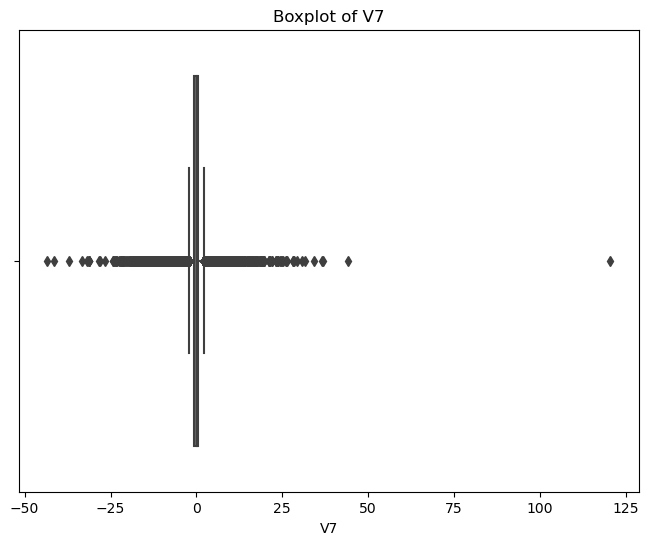

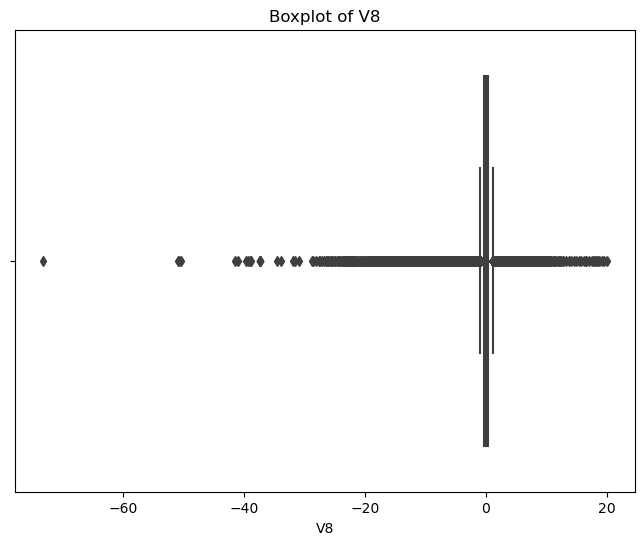

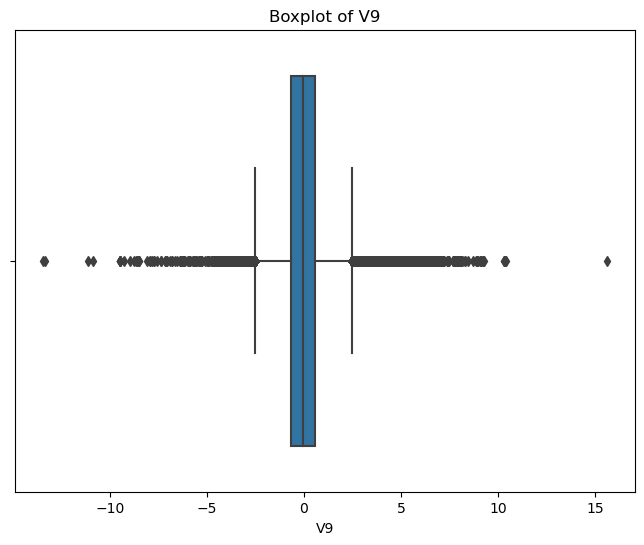

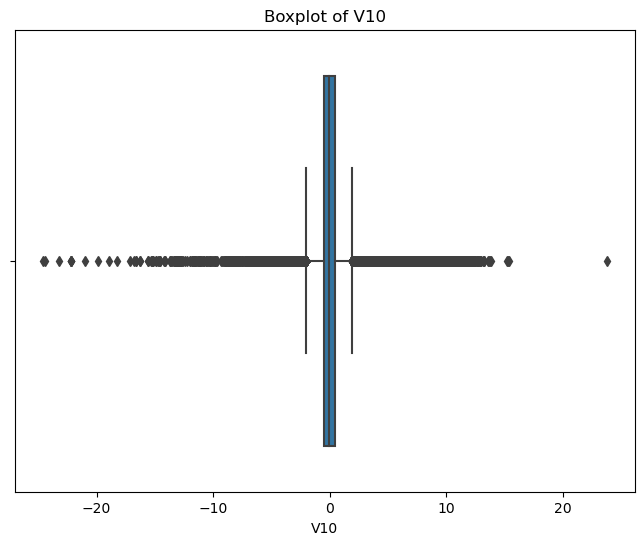

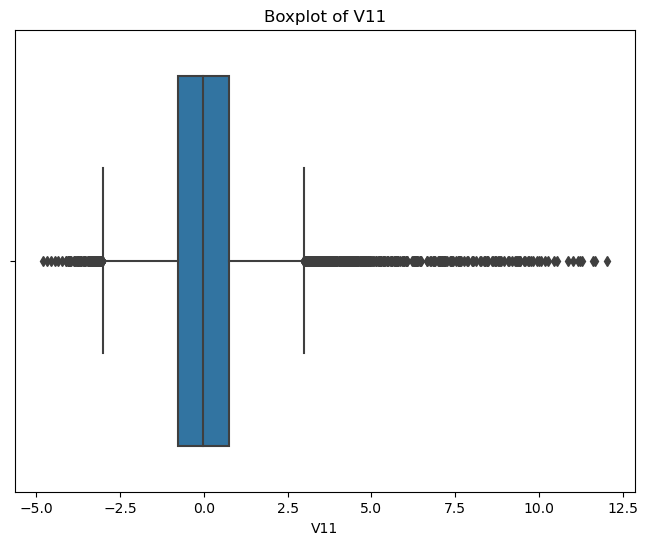

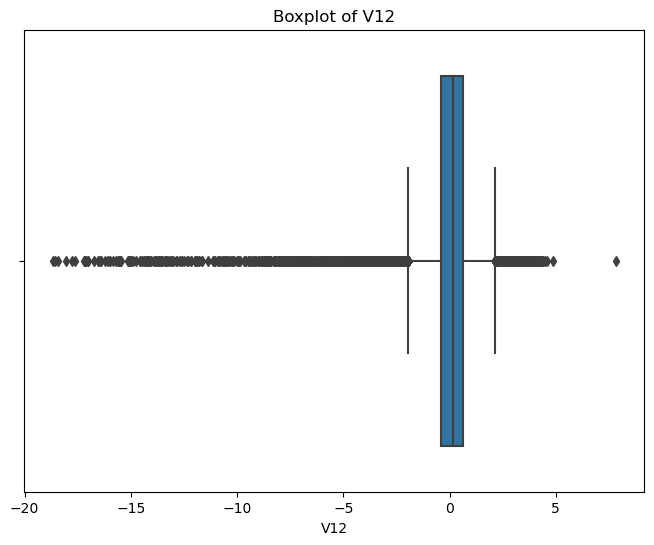

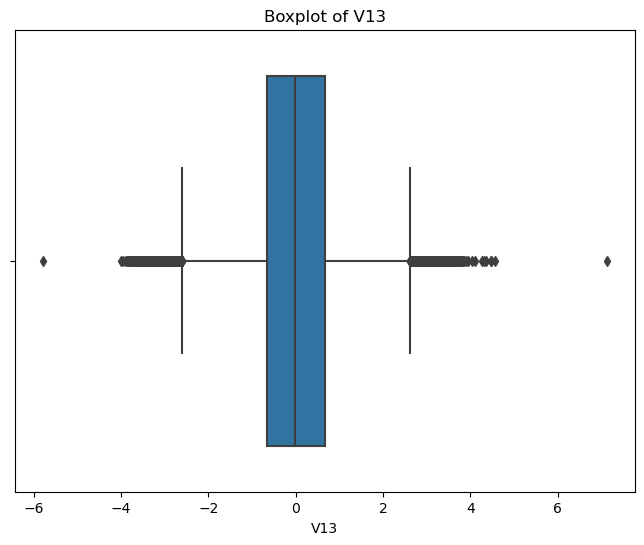

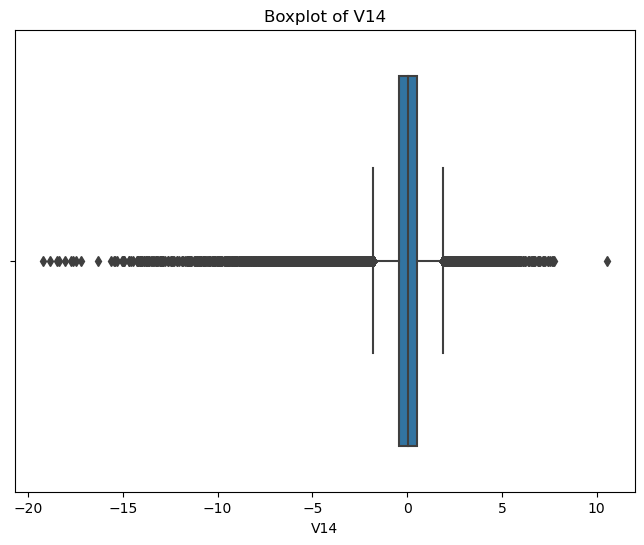

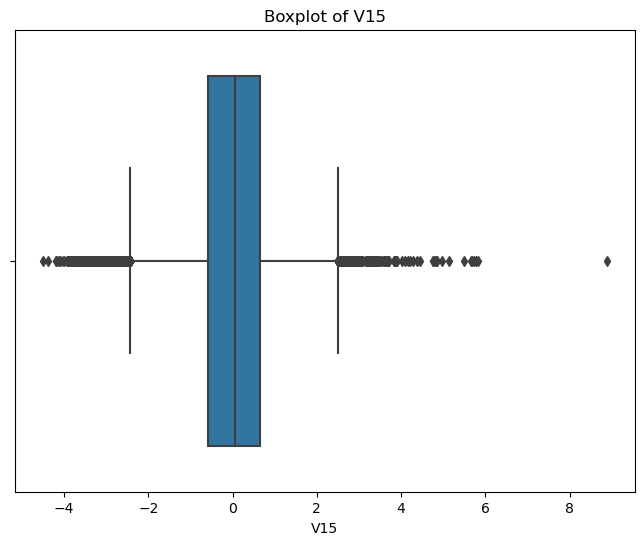

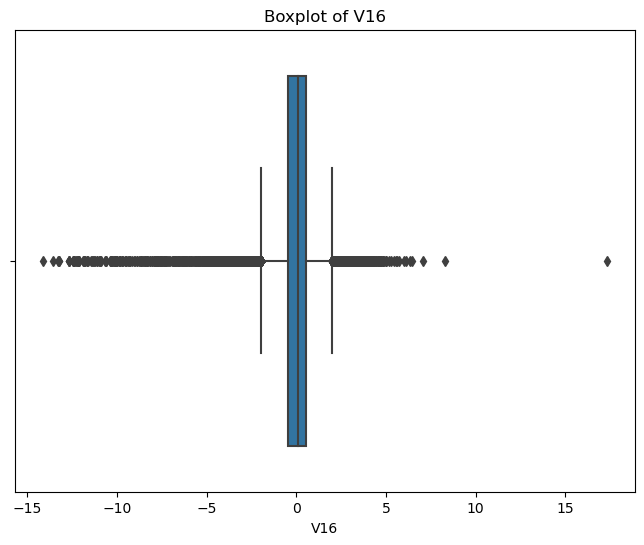

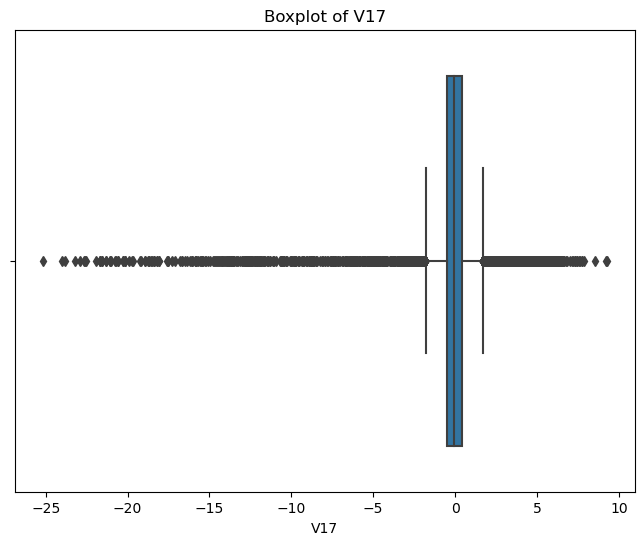

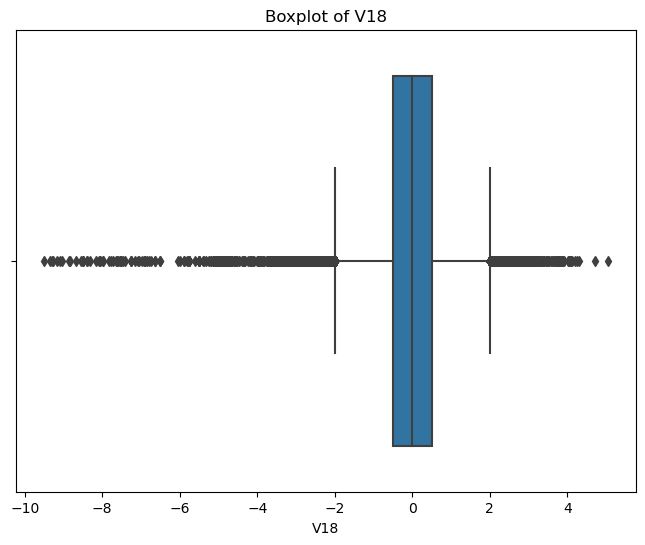

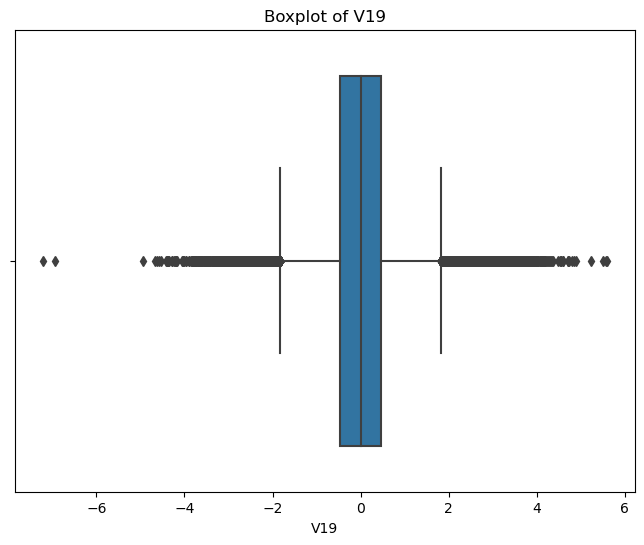

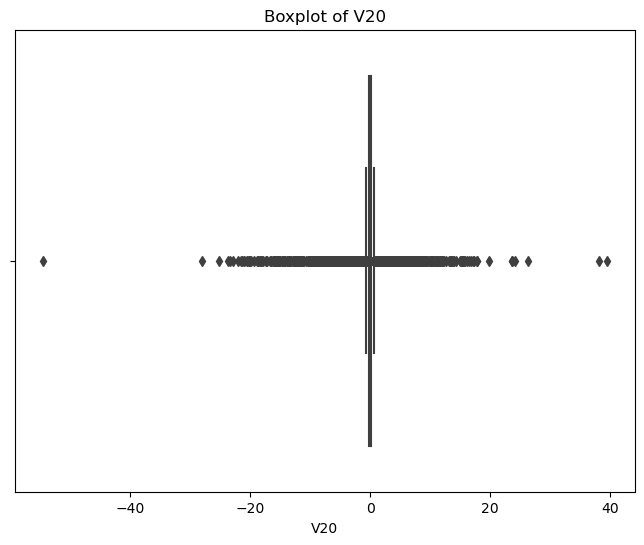

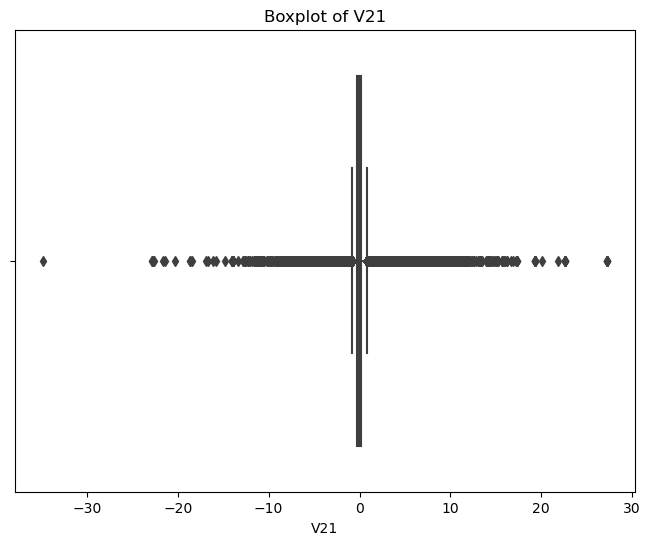

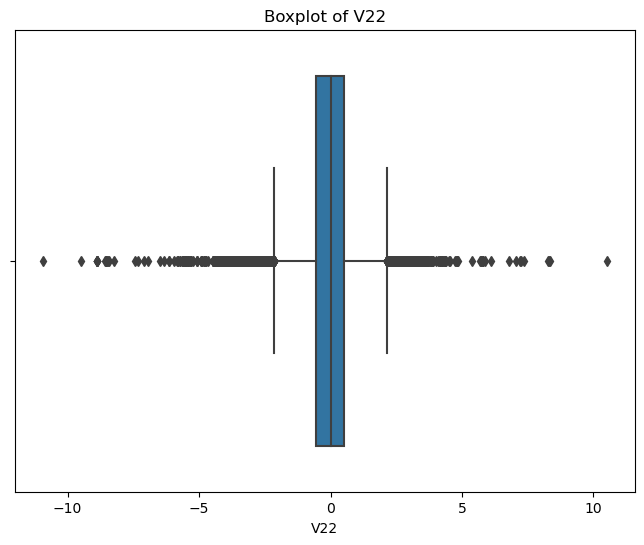

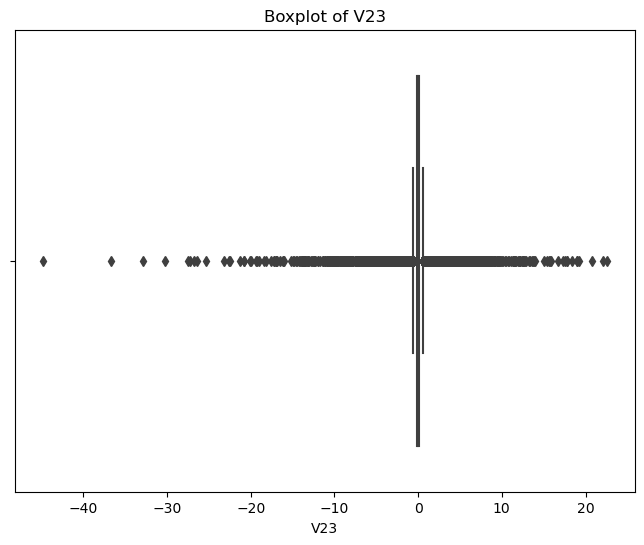

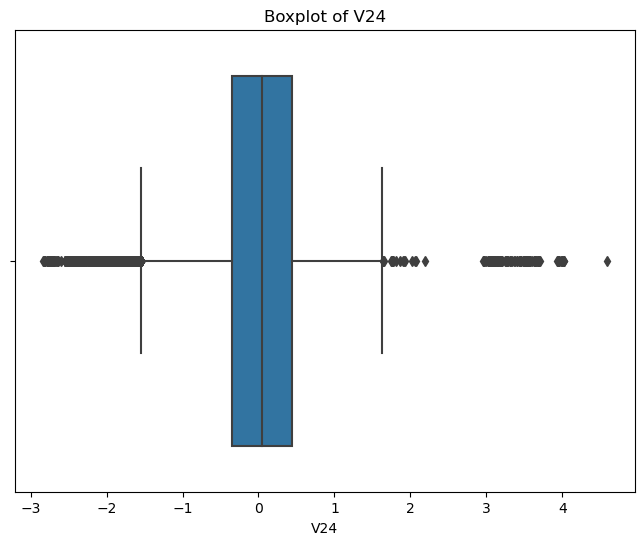

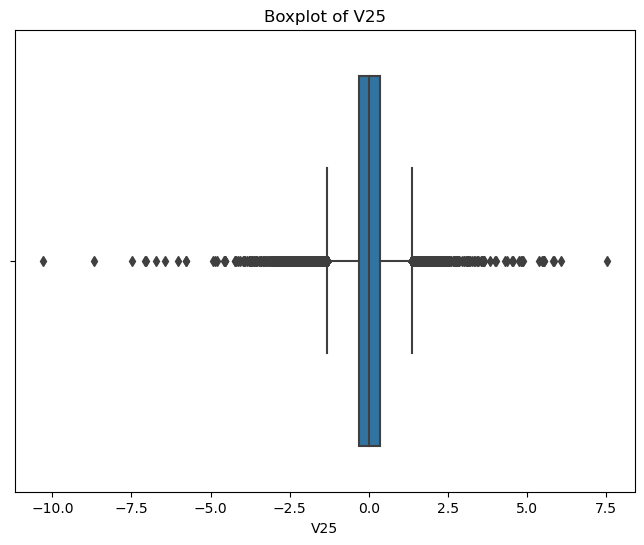

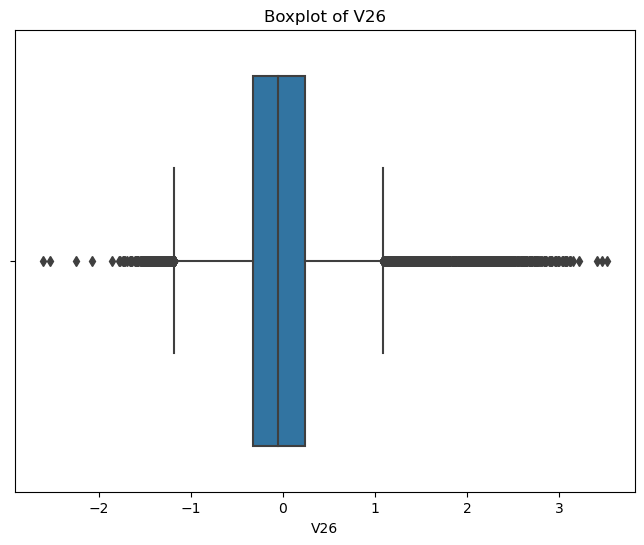

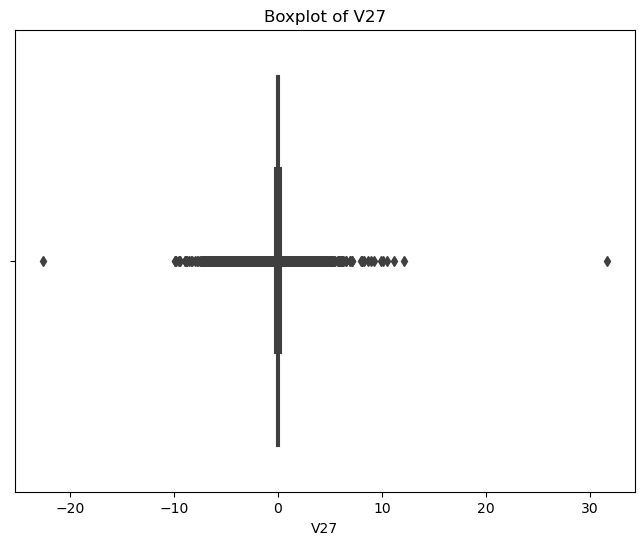

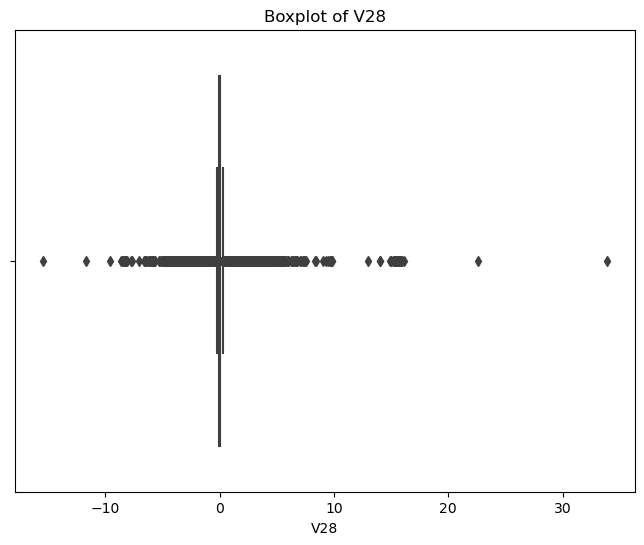

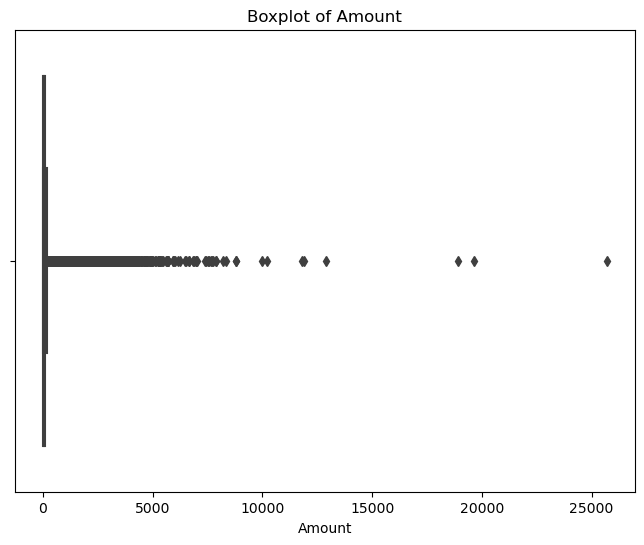

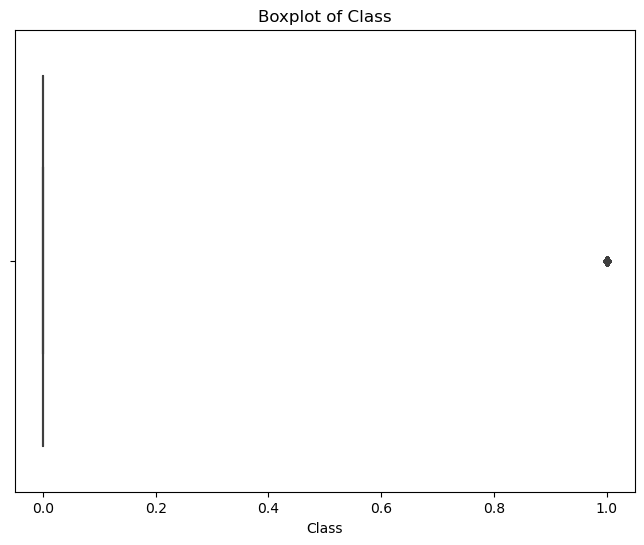

In [30]:
# Boxplot for detecting outliers
numeric_columns = data.select_dtypes(include=['int64', 'float64']).columns
for col in numeric_columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=data[col])
    plt.title(f'Boxplot of {col}')
    plt.show()


In [6]:


# Splitting data into features and labels
X = data.drop(columns=['Class'])  # Features
y = data['Class']  # Labels (0: Not Fraud, 1: Fraud)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)


Training data shape: (227845, 30)
Testing data shape: (56962, 30)


In [32]:


# Logistic Regression
log_model = LogisticRegression(random_state=42)
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)

print("Logistic Regression Results:\n", classification_report(y_test, y_pred_log))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log))

# Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("Random Forest Results:\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))



/Users/tauancosta/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Results:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.74      0.72      0.73        98

    accuracy                           1.00     56962
   macro avg       0.87      0.86      0.87     56962
weighted avg       1.00      1.00      1.00     56962

Confusion Matrix:
 [[56839    25]
 [   27    71]]
Random Forest Results:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.94      0.82      0.87        98

    accuracy                           1.00     56962
   macro avg       0.97      0.91      0.94     56962
weighted avg       1.00      1.00      1.00     56962

Confusion Matrix:
 [[56859     5]
 [   18    80]]




###### The Random Forest model outperforms Logistic Regression in detecting fraudulent transactions, particularly in terms of precision, recall, and the F1-score. However, it's important to notice that RF also take a lot more time to process everything and might not be the best option for a larger dataset that doesn't require great metrics (such as a small business data).  See the matrics from the RF as opposed to the LR:

True Positives (TP): 80 as opposed to 71 (correctly identified frauds)

True Negatives (TN): 56859 as opposed to  56839 (correctly identified non-frauds)

False Positives (FP): 5 as opposed to 25 (non-fraudulent transactions misclassified as fraud)


False Negatives (FN): 18 as opposed to 27 (fraudulent transactions missed)

## Enhanced Exploratory Data Analysis (EDA)

In this section, we will perform a more in-depth analysis of the dataset, including correlation analysis, distribution of key features, and the detection of outliers or anomalies.
    

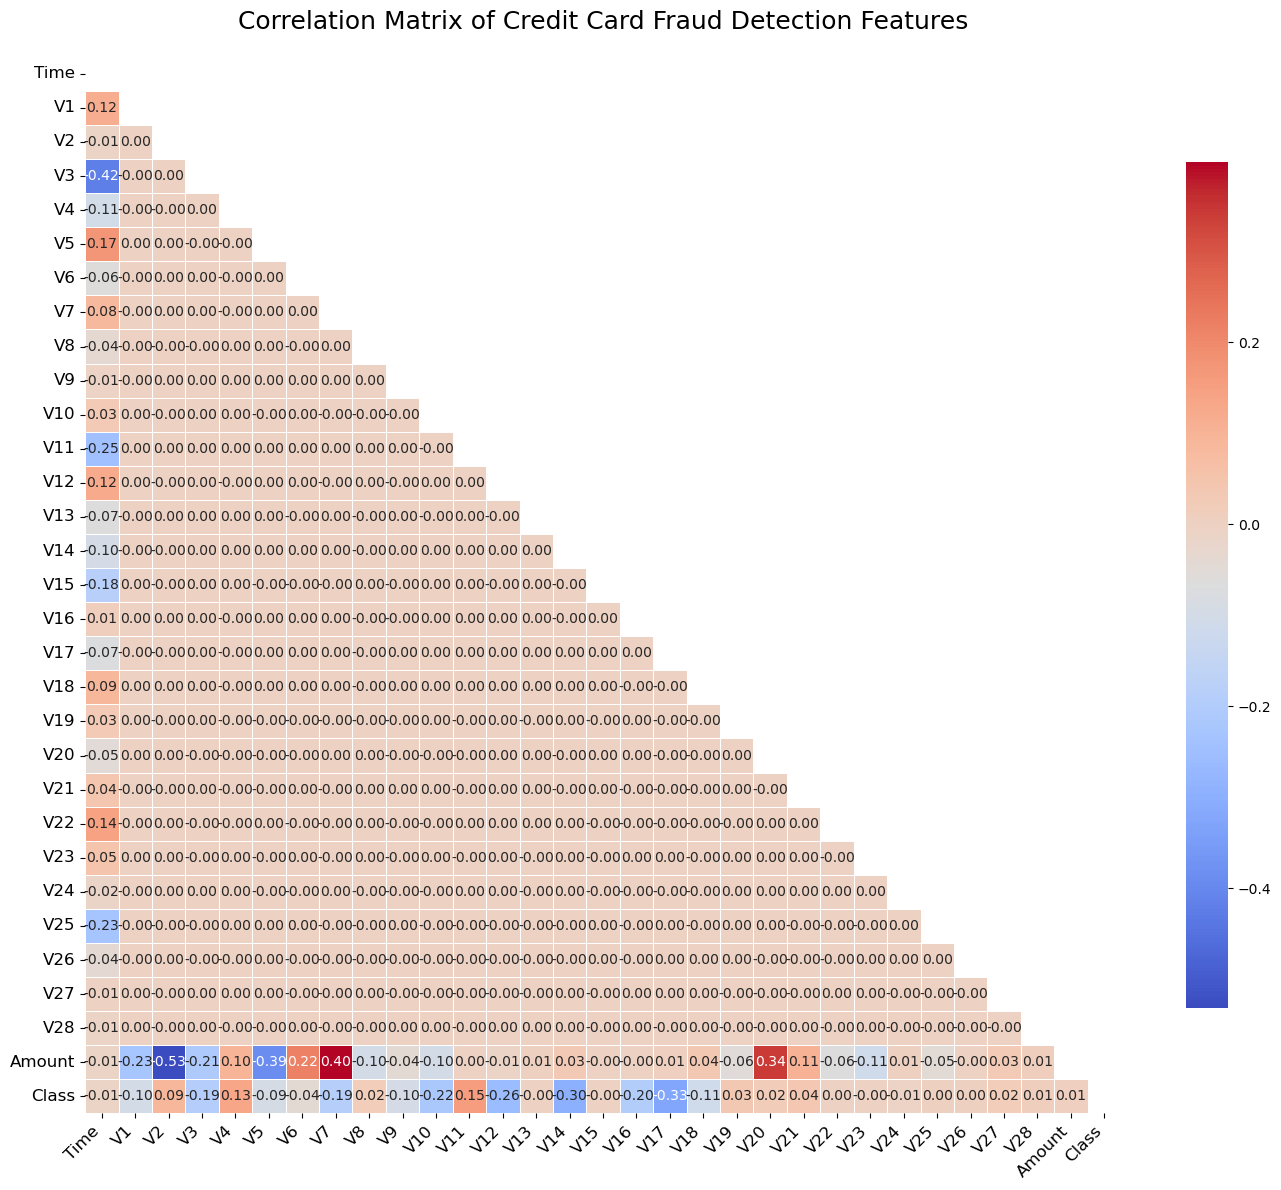

In [33]:
correlation_matrix = data.corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
# Set up the matplotlib figure
plt.figure(figsize=(14, 12))

# Customize the heatmap with more distinct colors and formatting
sns.heatmap(correlation_matrix, mask=mask, cmap='coolwarm', annot=True, fmt=".2f",
            annot_kws={"size": 10}, cbar_kws={"shrink": .8}, linewidths=0.5, linecolor='white')

# Rotate the x labels to make them easier to read
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Improve the title and layout
plt.title('Correlation Matrix of Credit Card Fraud Detection Features', fontsize=18, pad=20)
plt.tight_layout()

# Show the plot
plt.show()


    ## Unsupervised Learning Approach: Clustering with KMeans
    
    To detect potential fraudulent activities without using labeled data, we will apply KMeans clustering. 
    This unsupervised learning approach helps identify patterns or anomalies that may indicate fraudulent transactions.
    

In [11]:
# Using a sample for faster grid search
X_train_sample, _, y_train_sample, _ = train_test_split(X_train, y_train, train_size=0.2, stratify=y_train, random_state=42)

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10],
    'min_samples_split': [5, 10]
}
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)

print("Best Random Forest Results:\n", classification_report(y_test, y_pred_best_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best_rf))




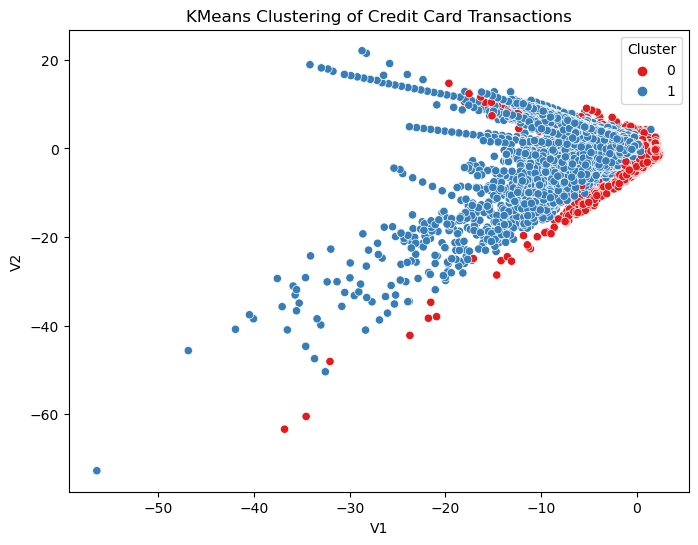

In [9]:


# Selecting a subset of features for clustering
features_for_clustering = data[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10']]

# Standardizing the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_for_clustering)

# Applying KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42)
data['Cluster'] = kmeans.fit_predict(scaled_features)

# Visualize the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x='V1', y='V2', hue='Cluster', data=data, palette='Set1')
plt.title('KMeans Clustering of Credit Card Transactions')
plt.show()


In [14]:
from sklearn.manifold import TSNE


# # Assuming you already have the data and clusters

# Step 1: Apply PCA to reduce dimensionality to 50 components
pca = PCA(n_components=50)
pca_result = pca.fit_transform(scaled_features)

# Step 2: Apply t-SNE to reduce the data to 2 dimensions
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(pca_result)

# Add the t-SNE result to the DataFrame for plotting
data['TSNE1'] = tsne_result[:, 0]
data['TSNE2'] = tsne_result[:, 1]

# Visualize the clusters using t-SNE results
plt.figure(figsize=(10, 8))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='Cluster', data=data, palette='Set1')
plt.title('t-SNE Visualization of Clusters in Credit Card Transactions')
plt.show()


In [10]:
features_for_clustering = data[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10']]

pca_X = features_for_clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(pca_X)




In [ ]:
# Applying Hierarchical Clustering
hierarchical = AgglomerativeClustering(n_clusters=2)
hierarchical_labels = hierarchical.fit_predict(pca_X)

In [ ]:
# Plotting DBSCAN results
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_X[:, 0], y=pca_X[:, 1], hue=dbscan_labels, palette='Set1')
plt.title('DBSCAN Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Plotting Hierarchical Clustering results
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_X[:, 0], y=pca_X[:, 1], hue=hierarchical_labels, palette='Set2')
plt.title('Hierarchical Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Calculate Silhouette Scores
silhouette_dbscan = silhouette_score(pca_X, dbscan_labels) if len(set(dbscan_labels)) > 1 else -1
silhouette_hierarchical = silhouette_score(pca_X, hierarchical_labels)

print(f'Silhouette Score for DBSCAN: {silhouette_dbscan}')
print(f'Silhouette Score for Hierarchical Clustering: {silhouette_hierarchical}')

DBSCAN achieved a silhouette score of 0.41, slightly outperforming hierarchical clustering, which scored 0.38. DBSCAN effectively identifies irregularly shaped clusters and handles noise well, making it ideal for detecting fraud in this context. However, it requires careful tuning of parameters like eps and min_samples. Hierarchical clustering, while useful for its clear structure and not needing a predefined number of clusters, performed slightly worse in this case, indicating it may not capture the data's nuances as effectively as DBSCAN.

Hierarchical clustering achieved a silhouette score of 0.38, indicating slightly lower cluster quality compared to DBSCAN. It forms clusters in a tree-like structure, offering a clear hierarchy without needing to pre-specify the number of clusters, though we set it to two for comparison. While it identified clusters, its performance was slightly less effective in capturing the data's structure.

## Conclusion

In this project, I set out to detect fraudulent credit card transactions using unsupervised learning. I started by exploring the dataset and used PCA and t-SNE to simplify and visualize the data, revealing hidden patterns. Then, I applied DBSCAN and hierarchical clustering to identify natural groupings, which could indicate potential fraud. I evaluated these clusters using silhouette scores to ensure they were meaningful. Through this process, I demonstrated how unsupervised learning can effectively uncover fraud, transforming complex data into actionable insights.